# <center>A Deep Dive Into My League of Legends Stats</center>
### <center> By Patrick Hogan </center>

<br> <br>
<img align="center" src="http://ddragon.leagueoflegends.com/cdn/img/champion/splash/TahmKench_0.jpg" alt="drawing" width="500"/> 

<br>
<br>

* * *

Introduction
------------------
League of Legends is a 2009 free-to-play multiplayer PC video game from Riot Games, and in its nearly 12 year run has become one of, if not the most popular esport on the planet. Millions upons millions of people around the world play the game, and like some **real** sports (e.g. Baseball), there are tons of statistics and data to sift through. In this tutorial I will show you the entire data science pipeline using my own personal data from the 2021 Ranked season thus far. I have been playing League of Legends since late 2015, but have only recently become more involved in playing the game competitively. Furthermore, this method can be applied to any player, with only minor tweaks depending on the role and amount of games played. I wanted a personalized, in depth look at what makes me a player. I think I delivered on that, but please, take a look for yourself!

The Game
--------------
League of Legends is referred to as a Multiplayer Online Battle Arena ([more about the MOBA genre](https://en.wikipedia.org/wiki/Multiplayer_online_battle_arena)). In League, or LoL, two teams of five are pitted against each other on the map [Summoner's Rift](https://static.wikia.nocookie.net/leagueoflegends/images/5/53/Summoner%27s_Rift_Update_Map.png/revision/latest/scale-to-width-down/1000?cb=20170223053555), which has remained largely the same over time. The main goal for both teams is to destroy the opposing team's base, represented by the Nexus. The first team to lose their Nexus (or forfeit) loses. There are countless other aspects of the game, such as vision score, neutral bosses, team composition, and itemization. It incorporates many elements from Real Time Strategy and Roleplaying games. To say it's a complex game would be an understatement. It also comes with an extremely steep learning curve, as many new players are typically much worse than regulars, and it takes time to understand the flow of the game, as well as mechanics. 

Why Was I Motivated to Work on This?
-----------------------------------------------
In League, the Summoner's Rift map consists of three lanes, which are long roads containing towers and various other terrain objects. For every role except Jungle, this is where the majority of a given match will be played. Everything not in one of the lanes is considered the Jungle. There are five roles: Top Lane, Jungle, Middle Lane, Bottom Lane, and Support (who also goes into the Bottom Lane). I have been playing Support as my main role for over 5 years (on and off), and I have mainly been playing the same character: Tahm Kench, pictured above. Read more about Tahm Kench [here](https://na.leagueoflegends.com/en-us/champions/tahm-kench/). Over time I have picked up various other characters, but to this day I am still mainly playing Tahm. This is important, as what characters I play will affect my interpretation of analyses. I chose to do my project on my personal statistics due to the fact that I am quite invested in this game, and I create my own data. In addition, I'm personally excited to see breakdowns of my statistics, specifically ones that most stat sites do not display. I will be answering and modeling various aspects of the game, such as team composition, enemy matchups, and kill participation in order to obtain a better understanding of how I play the game.


### Imports
In the Python below, we have to import some packages that contain essential functions. It's important that you don't reinvent the wheel when writing your code. There are plenty of off-the-shelf functions that these imports provide. Which ones you import may depend, but Pandas and Numpy are staples. Pandas is useful for representing data in a tabular format, known as DataFrames, and Numpy provides many mathematical functions. Pyplot allows us to plot data in meaningful and digestible ways. Read more about Pandas [here](https://pandas.pydata.org/), Numpy [here](https://numpy.org/) and matplotlib's pyplot [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html#:~:text=pyplot%20is%20a%20state%2Dbased,pyplot%20as%20plt%20x%20%3D%20np.).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import requests

Data Scraping and Wrangling
-----------------------------------------

To begin, let's retrieve my data from Riot's databases. Unfortunately the API is limited, and they still have not reviewed my application, so I am importing a text file here that contains my temporary API key. You can receive one via the [Riot Games Developer Portal](https://developer.riotgames.com/). This data is publicly available to anyone with an API key, and keys are free to obtain. Everything is stored in a JSON format at Riot, and since pandas supports JSON parsing, the data will be easy to represent.

In [2]:
# Opening the API key text file
with open ("api.txt", "r") as myfile:
    data=myfile.readlines()
    
api = data[0]

# Using the API to format the account API request URL properly.
request_account = "https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/OG%20Zoidberg?api_key={}".format(api)

In [3]:
# Riot utilizes JSON for their API, so I can convert the raw request module data into json using the appropriate function.
account_json = requests.get(request_account).json()
df = pd.DataFrame.from_dict(account_json, 'index')
# pandas supports json, so you can immediately put the json into a dataframe. It may need work, but it's a good start.

The produced dataframe contains some account details, none of which are super sensitive, since anyone can search my username, "OG Zoidberg", on the API. Anyways, now that we have the accountId, we can request from the match history API to receive a list of matches. Notice below there are several pandas DataFrames for matches. This is another limiation of the Riot API. The maximum number of games I can request is 100 per request, and I have played over 200 games, but less than 300. In addition, for the purposes of this assignment, I have stopped playing Ranked in order to ensure my dataset is of a fixed size. There are other important parameters to consider. Accoring to official documentation (found [here](https://developer.riotgames.com/docs/lol)), there is a file for Queue types (Ranked, Unranked, etc) as well as a file containing the different "season" identifications (though it is now deprecated, I can cross reference the amount of games I've played this season with the query in order to make sure I don't actually request any preseason or Season 2020 games or anything before that). The Queue ID for ranked is 420, and the Season ID is 13, so we can factor these into the three request URLs as well.

In [4]:
acc_id = df.iat[1,0] # Retrieving my accountID
acc_id
request_match_history = "https://na1.api.riotgames.com/lol/match/v4/matchlists/by-account/{}?queue=420&season=13&api_key={}".format(acc_id, api)
matches_json = requests.get(request_match_history).json()
match_df = pd.DataFrame.from_dict(matches_json) # We have a DataFrame for my most recent 100 matches now.

#according to the totalGames column, I have recorded more than 100 games this season, but the DataFrame only accounts for 100. We need to requery to get
#the rest of the games. This limitation is not on our end, but rather the API designer.
match_df2 = pd.DataFrame.from_dict(requests.get("https://na1.api.riotgames.com/lol/match/v4/matchlists/by-account/niRqhyE4liN4qzGIsmGuIO6jqEqbt6Qfj0IH8U_hV6E-468?queue=420&season=13&beginIndex=100&api_key={}".format(api)).json())
match_df3 = pd.DataFrame.from_dict(requests.get("https://na1.api.riotgames.com/lol/match/v4/matchlists/by-account/niRqhyE4liN4qzGIsmGuIO6jqEqbt6Qfj0IH8U_hV6E-468?queue=420&season=13&endIndex=272&beginIndex=200&api_key={}".format(api)).json())

In [5]:
match_df2

,matches,startIndex,endIndex,totalGames
0,"{'platformId': 'NA1', 'gameId': 3838696903, 'c...",100,200,304
1,"{'platformId': 'NA1', 'gameId': 3837335394, 'c...",100,200,304
2,"{'platformId': 'NA1', 'gameId': 3837166306, 'c...",100,200,304
3,"{'platformId': 'NA1', 'gameId': 3837133018, 'c...",100,200,304
4,"{'platformId': 'NA1', 'gameId': 3837069642, 'c...",100,200,304
...,...,...,...,...
95,"{'platformId': 'NA1', 'gameId': 3778279919, 'c...",100,200,304
96,"{'platformId': 'NA1', 'gameId': 3776881116, 'c...",100,200,304
97,"{'platformId': 'NA1', 'gameId': 3776668969, 'c...",100,200,304
98,"{'platformId': 'NA1', 'gameId': 3773560435, 'c...",100,200,304


This is an example output of a request. Here the only column worth anything is the first column, so we can put them all into a list, and then into a dataframe. We don't have to worry about the other columns since they are just static indices and are the same within each dataframe. The method I am using below uses three iterators, one for each dataframe, using the [.iterrows() function](https://pandas.pydata.org/pandas-docs/version/1.1.5/reference/api/pandas.DataFrame.iterrows.html). This was one way of doing it, but you could also just iterate through the indices and switch to the different dataframes at the correct intervals. That method would result in more code, though. In addition, the amount of loops will vary based on the amount of games you want to analyze. For example, an account like [HULKSMASH1337](https://na.op.gg/summoner/userName=HULKSMASH1337) has over 5 times the amount of games I have, so the amount of requests and loops would be much higher.

In [6]:
# Now let's make a list of just the matches columns throughout each table. Don't worry, this will be simple.
match_list = []
for index, row in match_df.iterrows():
    match_list.append(match_df.at[index, 'matches']) # Extracts match data from each row

for index, row in match_df2.iterrows():
    match_list.append(match_df2.at[index, 'matches'])
    
for index, row in match_df3.iterrows():
    match_list.append(match_df3.at[index, 'matches'])
     
matches = pd.DataFrame(match_list) # Let's see what an example match looks like

In [7]:
matches

,platformId,gameId,champion,queue,season,timestamp,role,lane
0,NA1,3891078743,223,420,13,1620000480427,DUO_SUPPORT,BOTTOM
1,NA1,3890814530,223,420,13,1619982025999,DUO_SUPPORT,MID
2,NA1,3887847786,223,420,13,1619808283274,DUO_SUPPORT,BOTTOM
3,NA1,3887833651,223,420,13,1619806038840,DUO_SUPPORT,BOTTOM
4,NA1,3884906923,50,420,13,1619637970972,DUO_SUPPORT,BOTTOM
...,...,...,...,...,...,...,...,...
267,NA1,3737087437,223,420,13,1610218825794,SOLO,BOTTOM
268,NA1,3736287048,223,420,13,1610159355278,DUO_SUPPORT,BOTTOM
269,NA1,3735983822,223,420,13,1610141302677,SOLO,MID
270,NA1,3735928268,115,420,13,1610138756604,SOLO,MID


Now that we have the list of match histories, we can remove all those in which I did **not** play support, or in other words, games in which I played outside of the bottom lane. The easiest way to do this is via checking my played characters, because the role and lane colummns are not always accurate. [According to my profile on OP.gg](https://na.op.gg/summoner/userName=OG%20Zoidberg), in addition to the 4 support characters, there are two middle lane mage characters: Azir and Ziggs. I am omitting these games as Middle Lane is not my main role, and they do not accurately reflect on me as a player. In addition, I played a single game of Tahm Kench middle at the start of the season due to an inattentive teammate. We can iterate through the dataframe and drop the rows were champion ID equals anything other than 223 (Tahm Kench), 50 (Swain), 267 (Nami), and 412 (Thresh), as these are the only Support characters I have played during this Season. These values are given via [the champion json file](http://ddragon.leagueoflegends.com/cdn/11.9.1/data/en_US/champion.json). In addition, I remember my first two games of the season were played on Ziggs, and you can tell that the requests were correct given the last two rows have ID 115 for Ziggs.

In [8]:
to_rem_list = []
for index, row in matches.iterrows():
    if matches.iat[index, 2] != 223 and matches.iat[index, 2] != 50 and matches.iat[index, 2] != 267 and matches.iat[index, 2] != 412:
        to_rem_list.append(index)
        
for x in to_rem_list:
    matches = matches.drop(x)

Now to remove the Tahm Mid game, since it won't be useful in my analyses:

In [9]:
matches = matches.drop(269)

In [10]:
match_list_detailed = []
import time
matches = matches.reset_index() # resetting indices so the following loop will ACTUALLY work :)

We have some kind of data, but it's really not what we want, or need. Using the API again, we can use the gameId field with the NA1_ prefix (since I play on the North American server) to get a list of detailed match statistics. The API has a rate limit, so this always takes a few minutes to complete. I imported the time module above in order to prevent a break in the rate limit. You could change the code for different servers, such as the Korean server or one of the many European servers.

In [11]:
for index, row in matches.iterrows():
    time.sleep(1.3)
    game_example_dict = requests.get("https://americas.api.riotgames.com/lol/match/v5/matches/NA1_{}?api_key={}".format(matches.iat[index, 2], api)).json()
    match_list_detailed.append((game_example_dict['info'])['participants'])

In [12]:
df_list = []
for x in match_list_detailed:
    df_list.append(pd.DataFrame(x))

Let's drop some of the columns we don't need:

In [13]:
df_list2 = []
for data in df_list:
    df_list2.append(data.drop(columns=['championTransform', 'participantId', 'perks', 'profileIcon', 'riotIdTagline', 'sightWardsBoughtInGame', 'summonerId', 'summonerLevel', 'timePlayed','bountyLevel','champExperience','consumablesPurchased', 'unrealKills','spell1Casts','spell2Casts','spell3Casts','spell4Casts']))

This should give us a list of match dataframes. I also dropped several columns that will not be useful in our analysis, like bounties, ability cast numbers, and more. Now we can actually explore this data and find things the League Client won't tell you! Let's see what a single game looks like.

In [14]:
pd.set_option('display.max_columns', 20)
df_list2[0]

,assists,baronKills,champLevel,championId,championName,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,deaths,...,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,turretsLost,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
0,1,0,17,62,MonkeyKing,8103,29974,8103,27326,5,...,10929,1485,1355,7,5,26,2,5,12,True
1,8,0,15,121,Khazix,467,19758,467,20291,11,...,9919,187,1275,0,5,30,3,4,5,True
2,7,0,17,74,Heimerdinger,9467,18869,9467,11781,9,...,6207,744,723,2,5,33,3,2,14,True
3,5,0,14,202,Jhin,1285,4531,1285,8915,11,...,410,168,1368,0,5,14,1,2,8,True
4,10,0,13,223,TahmKench,117,1407,117,41249,7,...,4240,0,2331,1,5,55,3,5,22,True
5,11,0,14,114,Fiora,370,1471,370,16410,8,...,20220,4610,324,0,10,22,2,5,12,False
6,8,0,16,64,LeeSin,0,14219,0,32768,8,...,5689,734,357,0,10,43,13,4,20,False
7,14,0,18,8,Vladimir,1492,1492,1492,14985,8,...,1410,1016,728,1,10,30,3,2,15,False
8,16,0,17,51,Caitlyn,11417,17893,11417,10754,8,...,2243,693,692,3,10,18,1,2,12,False
9,16,0,16,101,Xerath,1734,1734,1734,7138,6,...,276,0,483,0,10,50,0,2,28,False


That's a lot of columns! As you can see very many stats go into the game overall. These column names are given by Riot, and if I use one, I will explain its name if it is not apparent. This was my most recent ranked game, since they are recorded with the newest games appearing at the top. It looks like my team won this game, but now we can start to use this data for analysis and representation.

Data Analysis 1: Keep Your Friends Close...
--------------------
We're finally on to the nitty-gritty of the project, where we, as Data Scientists, have to make sense of it all. There are many statistics I could focus on such as overall win rate, win rate over time, Wards bought vs Wins, and more. First, let's take a look at my lane partners: Bottom Laners, typically referred to as ADCs. Attack Damage Carries (ADCs) are a class of character typically played alongside supports in the bottom lane. In addition to these characters, there are also several flex picks (typically mages). Team Composition is one of the most important aspects of League, as many games can be decided before the game even begins. Some teams pick a more balanced composition, while others may be extremely unbalanced or underpowered. Let's go through each game, find out who my lane partner was, and whether or not we won. The following code block carefully retrieves rows from each game and finds the ADC. There are two special cases in which teammates swapped roles, so I have to take those into account. There are various ways to achieve this, and some are likely less lengthy than this. As long as you get the data you need, it should not cause much concern.

In [15]:
adc_dict = {}
i = 0
while i < 267:
    # The method in which one finds the ADC is easy, since they are always displayed next to me. In the above DF you can see
    # TahmKench as the championName in row 4. The ADC is always rowindex-1 compared to me. 
    id = df_list2[i].loc[df_list2[i]['summonerName'] == "OG Zoidberg"].index[0]-1
    adc_row = df_list2[i].iloc[[id]]
    adc_name = adc_row.iat[0, 4]
    
    if i == 199:      # SPECIAL CASE: KATARINA. Katarina swapped with my ADC leading to a mismatch in the dataframe.
        id = df_list2[i].loc[df_list2[i]['summonerName'] == "OG Zoidberg"].index[0]-2
        adc_row = df_list2[i].iloc[[id]]
        adc_name = adc_row.iat[0, 4]
        if adc_name in adc_dict:
            tup = adc_dict.get(adc_name)
            if adc_row.iat[0, 84]:
                adc_dict[adc_name] = (tup[0] + 1, tup[1] + 1)
            else:
                adc_dict[adc_name] = (tup[0], tup[1]+1)
            
        else:
            if adc_row.iat[0,84]:
                adc_dict[adc_name] = (1,1)
            else:
                adc_dict[adc_name] = (0,1)
    
    elif i == 75:     # SPECIAL CASE: VOLIBEAR. Volibear swapped with my ADC leading to a mismatch in the dataframe.
        id = df_list2[i].loc[df_list2[i]['summonerName'] == "OG Zoidberg"].index[0]-3
        adc_row = df_list2[i].iloc[[id]]
        adc_name = adc_row.iat[0, 4]
        if adc_name in adc_dict:
            tup = adc_dict.get(adc_name)
            if adc_row.iat[0, 84]:
                adc_dict[adc_name] = (tup[0] + 1, tup[1] + 1)
            else:
                adc_dict[adc_name] = (tup[0], tup[1]+1)
            
        else:
            if adc_row.iat[0,84]:
                adc_dict[adc_name] = (1,1)
            else:
                adc_dict[adc_name] = (0,1)
    
    elif i < 200:        # Normal case pre-200
        if adc_name in adc_dict:
            tup = adc_dict.get(adc_name)
            if adc_row.iat[0, 84]:
                adc_dict[adc_name] = (tup[0] + 1, tup[1] + 1) # Increment both elements for a win
            else:
                adc_dict[adc_name] = (tup[0], tup[1]+1)
            
        else:
            if adc_row.iat[0,84]:
                adc_dict[adc_name] = (1,1)
            else:
                adc_dict[adc_name] = (0,1)
                
    else:                # For some reason there are less columns in the games after 0-199 in the list, need to take that into account.
        if adc_name in adc_dict:
            tup = adc_dict.get(adc_name)
            if adc_row.iat[0, 80]:
                adc_dict[adc_name] = (tup[0] + 1, tup[1] + 1)
            else:
                adc_dict[adc_name] = (tup[0], tup[1]+1)
            
        else:
            if adc_row.iat[0,80]:
                adc_dict[adc_name] = (1,1)
            else:
                adc_dict[adc_name] = (0,1)
    
   
    i += 1

After that long-winded algorithm we should have a dictionary containing each ADC, as well as the number of times I have played with them, and our wins. Notice how I used .iat for calling data. This meant I had to account for the change in number of columns after index 199. If you want less lengthy code you can just use .at with the column name in the second position. It's another way to compute the same thing, essentially.

In [16]:
adc_wins = pd.DataFrame.from_dict(adc_dict, orient='index')
adc_wins.columns = ['wins', 'games_played']
# Renaming cols for accessibility.

In [17]:
adc_wins['win_rate'] = 0.0
for index, row in adc_wins.iterrows():
    adc_wins.at[index, 'win_rate'] = float(adc_wins.at[index, 'wins'])/float(adc_wins.at[index, 'games_played'])
    
# Calculating win percentage

Let's plot the data. We can use a bar graph to plot the win rates per champion. We can use the built in plot method with pandas. To increase readability we can also specify labels for both axes as well as a title.

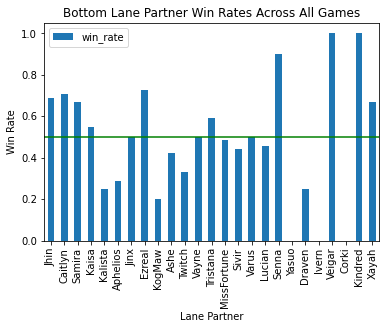

In [18]:
plot = adc_wins.plot(kind='bar', y='win_rate', xlabel='Lane Partner', ylabel='Win Rate', title="Bottom Lane Partner Win Rates Across All Games")
plot.axhline(y = 0.5, color='g')

This graph is a little bit misleading though, since the games played differ across all of the champions. We can calculate the appearance percentage for each champion in order to filter out lower appearance rates.

In [19]:
adc_wins['appearance_rate'] = 0.0
for index, row in adc_wins.iterrows():
    adc_wins.at[index, 'appearance_rate'] = float(adc_wins.at[index, 'games_played'])/float(len(df_list2))
    
# calculating appearance rate (games played against / total games)

There are many instances of champions with extremely low appearance rates. This is due to the current competitive "meta", in which people tend to play a handful of strong champions, while never playing others. In my case, Tahm Kench Support is very rare, since the [patch history](https://leagueoflegends.fandom.com/wiki/Tahm_Kench/LoL/Patch_history) has not been particularly kind to him over the years, and his pick rate currently sits at [1.1% in the support role across all ranks](https://u.gg/lol/champions/tahmkench/build?rank=overall&role=support) at the time of writing. Let's just remove all of the champions that have less than a 4 percent appearance rate as my lane partner. We can accumulate these in a list, and then make a copy of the original dataframe as to prevent indexing errors.

In [20]:
champs_to_drop = []
for index, row in adc_wins.iterrows():
    if adc_wins.at[index, 'appearance_rate'] < 0.04:
        champs_to_drop.append(index)
        
new_adc_list = pd.DataFrame.copy(adc_wins)
for champ in champs_to_drop:
    new_adc_list = new_adc_list.drop(champ)
    
new_adc_list # let's see the "most common" ADCs in my games.

,wins,games_played,win_rate,appearance_rate
Jhin,20,29,0.689655,0.108614
Caitlyn,12,17,0.705882,0.063670
Samira,8,12,0.666667,0.044944
Kaisa,11,20,0.550000,0.074906
Jinx,9,18,0.500000,0.067416
Ezreal,8,11,0.727273,0.041199
Ashe,8,19,0.421053,0.071161
Tristana,16,27,0.592593,0.101124
MissFortune,17,35,0.485714,0.131086
Lucian,5,11,0.454545,0.041199


<AxesSubplot:title={'center':'Most Frequent Partner Win Rates'}, xlabel='Lane Partner', ylabel='Win Rate'>

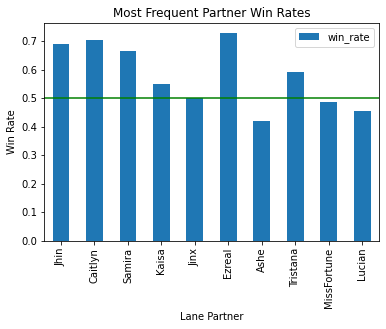

In [21]:
plot2 = new_adc_list.plot(kind='bar', y='win_rate', xlabel='Lane Partner', ylabel='Win Rate', title="Most Frequent Partner Win Rates")
plot2.axhline(y = 0.5, color='g')
plot2 # Plotting based on Win Rate

The above graph shows my win rates with the current "meta" ADCs that I have to partner up with. As you can see, my win rate is the highest when I play with Ezreal, but that's only across 11 games! My most common partner is Miss Fortune, with a 13 percent appearance rate, but with a sub-50 percent win rate, which is typically considered bad. As such, I have placed a line at y=0.5 in order to clarify which win rates are considered good and which are considered subpar. The second highest partner in my match history is Jhin, and with an astounding win rate of nearly 69 percent, it's no surprise as to why he has one of the highest pick rates for the role, at 17.4% in Silver at the time of writing. These stats were found on [U.GG](https://u.gg/lol/champions/jhin/build?rank=silver).

Data Analysis 2: ...And Your Enemies Closer
------------

Matchups and synergies play a huge role in the League of Legends. Good players know all of the best and worst matchups for their character, and especially who to ban during the character selection phase. However, each player only gets one ban, so if your character has many counters, you might have to take the risk. It depends on who picks their character first. The next questions I want to answer are "Who am I the best against?" and "Who am I worst against?" When someone asks me these questions I have some instinctual answers based on my personal experiences, but let's see what the numbers have to say.

We can answer both of these questions at the same time. Using a similar methodology as above we can find the enemy supports, as they are always listed as the last row for their team, unless someone swapped in character selection. Like above, we can pretty easily find out in which games that took place. There is only one special case this time, instead of two like before. The algorithm is bascially the same.

In [22]:
# Essentially the same code as above, but with less error cases (index 92) and different var names.
supp_dict = {}
i = 0
while i < 267:
    if i == 92: # Special case: Jhin and Swain swapped. I believe they were a duo.
        id = df_list2[i].loc[df_list2[i]['summonerName'] == "OG Zoidberg"].index[0]+4
        supp_row = df_list2[i].iloc[[id]]
        supp_name = supp_row.iat[0,4]
        if supp_name in supp_dict:
            tup = supp_dict.get(supp_name)
            if supp_row.iat[0, 84]:
                supp_dict[supp_name] = (tup[0], tup[1] + 1)
            else:
                supp_dict[supp_name] = (tup[0]+1, tup[1]+1)
            
        else:
            if supp_row.iat[0,84]:
                supp_dict[supp_name] = (0,1)
            else:
                supp_dict[supp_name] = (1,1)
    else:
        
        id = df_list2[i].loc[df_list2[i]['summonerName'] == "OG Zoidberg"].index[0]
        supp_row = df_list2[i].iloc[[id]]
        supp_name = ""
        if id == 4:
            supp_row = df_list2[i].iloc[[id+5]]
            supp_name = supp_row.iat[0, 4]
        
        else:
            supp_row = df_list2[i].iloc[[id-5]]
            supp_name = supp_row.iat[0, 4]
        
        
        if i < 200:
            if supp_name in supp_dict:
                tup = supp_dict.get(supp_name)
                if supp_row.iat[0, 84]:
                    supp_dict[supp_name] = (tup[0], tup[1] + 1)
                else:
                    supp_dict[supp_name] = (tup[0]+1, tup[1]+1)
            
            else:
                if supp_row.iat[0,84]:
                    supp_dict[supp_name] = (0,1)
                else:
                    supp_dict[supp_name] = (1,1)
                
        else:
            if supp_name in supp_dict:
                tup = supp_dict.get(supp_name)
                if supp_row.iat[0, 80]:
                    supp_dict[supp_name] = (tup[0], tup[1] + 1)
                else:
                    supp_dict[supp_name] = (tup[0]+1, tup[1]+1)
            
            else:
                if supp_row.iat[0,80]:
                    supp_dict[supp_name] = (0,1)
                else:
                    supp_dict[supp_name] = (1,1)
                
    i+=1

Nice, we have the data we need for the enemy supports now. First, I'd like to compare the amount of different ADCs I've played with vs the amount of supports I've played against.

In [23]:
len(adc_dict)

25

In [24]:
len(supp_dict)

46

That's nearly double! There is an issue of diversity in the types of characters played in the bottom role, but less so for support. With that out of the way, let's see the overall win rates I have against these opponents. First let's calculate the win rates, then plot them as above.

In [25]:
supp_wins = pd.DataFrame.from_dict(supp_dict, orient='index')
supp_wins.columns = ['wins_against', 'games_played_against']

In [26]:
supp_wins['win_rate'] = 0.0
for index, row in supp_wins.iterrows():
    supp_wins.at[index, 'win_rate'] = float(supp_wins.at[index, 'wins_against'])/float(supp_wins.at[index, 'games_played_against'])

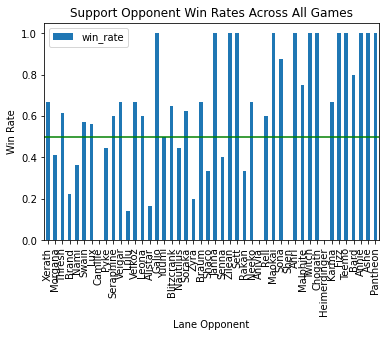

In [27]:
plot = supp_wins.plot(kind='bar', y='win_rate', xlabel='Lane Opponent', ylabel='Win Rate', title="Support Opponent Win Rates Across All Games")
plot.axhline(y = 0.5, color='g')

This graph is too visually noisy to be useful. We can clean it up by using appearance rate again.

In [28]:
supp_wins['appearance_rate'] = 0.0
for index, row in supp_wins.iterrows():
    supp_wins.at[index, 'appearance_rate'] = float(supp_wins.at[index, 'games_played_against'])/float(len(df_list2))

For this, let's say anything below 2.5 percent can be dropped. I chose this number because one of the characters with the lowest appearance rates in the below DataFrame is Lulu, who is very much a "meta" characters, especially in higher ranks. I thought it would be best to use this percentage as to incorporate some of the more overall popular characters in this role.

In [29]:
champs_to_drop = []
for index, row in supp_wins.iterrows():
    if supp_wins.at[index, 'appearance_rate'] < 0.025:
        champs_to_drop.append(index)
        
new_supp_list = pd.DataFrame.copy(supp_wins)
for champ in champs_to_drop:
    new_supp_list = new_supp_list.drop(champ)

Let's take a look at the new list and see who is in it.

In [30]:
new_supp_list

,wins_against,games_played_against,win_rate,appearance_rate
Morgana,7,17,0.411765,0.063670
Thresh,8,13,0.615385,0.048689
Brand,2,9,0.222222,0.033708
Nami,4,11,0.363636,0.041199
Swain,4,7,0.571429,0.026217
Lux,14,25,0.560000,0.093633
Pyke,4,9,0.444444,0.033708
Seraphine,6,10,0.600000,0.037453
Lulu,1,7,0.142857,0.026217
Leona,9,15,0.600000,0.056180


My most common matchups are against Lux, a high-damage mage, and Blitzcrank, a tanky support that relies on hooking enemies into him. It's interesting to note that across the six most played against supports, the win rates are closer to 50% than most of the lower entries, which intuitively makes sense. If you've only played against a certain character in 7 matches there's a higher chance it can get skewed because the sample size is so low.

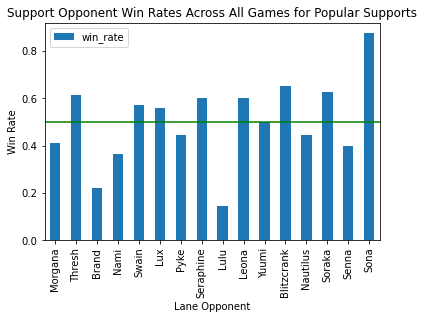

In [31]:
plot3 = new_supp_list.plot(kind='bar', y='win_rate', xlabel='Lane Opponent', ylabel='Win Rate', title="Support Opponent Win Rates Across All Games for Popular Supports")
plot3.axhline(y = 0.5, color='g') # adding the line to denote 50% win rate

According to this graph, I'm best against Sona and worst against Lulu. Sona is considered to be very weak right now, so the fact that she typically loses games is not surprising. However, according to U.GG, [she has a win rate of 57.75 against Tahm Kench across 213 games](https://u.gg/lol/champions/sona/build?rank=silver&opp=tahmkench) in Silver, so perhaps I am the exception, not the rule. I consider Lulu, Senna, and Brand to be my worst matchups, and given my match history this is corraborated. Lulu is the lowest at 1 win across 7 games, followed by Brand at 2 wins across 9 games, and finally Senna at 6 wins across 15 games. As a result of playing against Senna, who is much more common compared to the former two, I started banning her in nearly all of my games. Some surprises here are my above-50% win rates against high-damage mages like Swain, Lux, and Seraphine, as well as my low win rates against Pyke and Nautilus, which are both matchups I typically consider even or in my favor, at least when I play Tahm Kench. With this information I can play safer in future games in matchups like these.

Data Anaylsis 3: Participation is Important
-------------------------

Okay, well those are pretty simple representations of exploratory data analysis. Let's look at something that requires some hypothesis testing and machine learning. Let's take a look at something that many supports consider to be an important metric of performance: Kill Participation (KP). It's a simple metric, being only the sum of kills and assists, with the latter being more important due to the fact that supports typically want to give the damage-dealing characters the kills, due to gold rewards.

### Getting the data Together

We need to figure out how to get a list of win rates per KP number. We can use a similar methodoloy as above and repurpose the code once more. Instead of recording the wins based on the character's name, we can use the KP totals instead. Once again there are various ways to find this data, but I find [tuples](https://docs.python.org/3.3/library/stdtypes.html?highlight=tuple#tuple) to be epecially convienient structures for this purpose.

In [32]:
kp_dict = {}
# Looping through the games and recording my Kill Participation and if I won the game. Stored in a dict.
for game in df_list2:
    id = game.loc[game['summonerName'] == "OG Zoidberg"].index[0]
    assists = game.at[id, 'assists']
    kills = game.at[id, 'kills']
    kp = kills+assists
    if game.at[id, 'win'] == True:
        if kp in kp_dict:
            tup = kp_dict.get(kp)
            kp_dict[kp] = (tup[0]+1, tup[1] + 1) # Using the tuple method as before
        else:
            kp_dict[kp] = (1,1)
            
    elif game.at[id, 'win'] == False:
        if kp in kp_dict:
            tup = kp_dict.get(kp)
            kp_dict[kp] = (tup[0], tup[1] + 1)
        else:
            kp_dict[kp] = (0,1)
            
kp_df = pd.DataFrame.from_dict(kp_dict, orient='index')
kp_df.columns = ['game_won', 'games_ocurred']
kp_df = kp_df.sort_index()

Now we can calculate the win rate for each KP number.

<AxesSubplot:xlabel='kill_participation', ylabel='win_rate'>

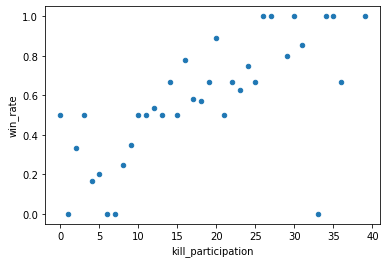

In [33]:
kp_df2 = kp_df.reset_index() # resetting the indices for ease in graphing
kp_df2['win_rate'] = 0.0
kp_df2.columns = ['kill_participation','game_won','games_ocurred','win_rate']
# Calculating win rate for each KP number.
for index, row in kp_df2.iterrows():
    kp_df2.at[index, 'win_rate'] = float(kp_df2.at[index, 'game_won'])/float(kp_df2.at[index, 'games_ocurred'])
    
kp_df2.plot(kind='scatter',x='kill_participation',y='win_rate')

Excellent, we have a plot of win rate against KP now. You may notice a few outliers, like the 33 KP with 0 percent win rate, or the 50% win rate for 0 KP. For the former, it was an unusually long game that was even for both teams. For the latter, I did some research into those games and found out those were both remakes. A Remake is when someone on either team disconnects, allowing the team with the disconnecting player to surrender as soon as the game starts, preventing a loss in rank. However, the games are still recorded in the database as win or loss. Both 0 KP games were remakes, one of which had a teammate of mine disconnect. Anyways, let's fit a line to this graph. Let's first try linear regression to see how well it fits. Let's use Numpy's polyfit feature alongside [matplotlib's pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html).

Text(0.5, 1.0, 'Kill Participation (kills + assists) Against Win Rate')

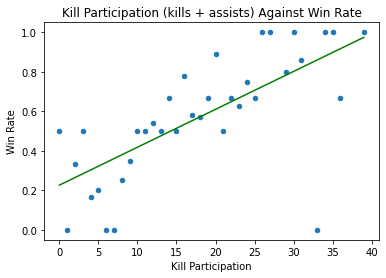

In [34]:
kp_df2.plot(kind='scatter',x='kill_participation',y='win_rate')
X=kp_df2['kill_participation']
y=kp_df2['win_rate']
m, b = np.polyfit(X, y, 1) # Coefficients 0.01916738 and 0.22667317

mpl.plot(X, m*X + b, color='g') # plots the line, making it green
# Let's make the graph a bit prettier.
mpl.xlabel("Kill Participation")
mpl.ylabel("Win Rate")
mpl.title("Kill Participation (kills + assists) Against Win Rate")

This fit isn't too great. Let's take a look at the residuals though. 

In [35]:
def resid_calc(kp, winrate):
    ax = 0.01916738*kp
    y = (ax) + 0.22667317
    return winrate - y

Text(0.5, 1.0, 'Kill Participation Against Residual Win Rate')

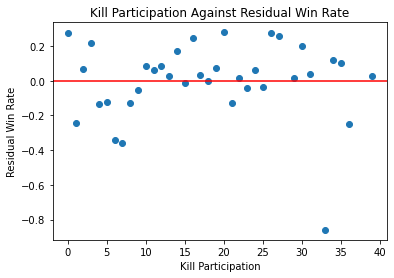

In [36]:
resids_list = []
for index, row in kp_df2.iterrows():
    resids_list.append(resid_calc(kp_df2.at[index, 'kill_participation'], kp_df2.at[index, 'win_rate']))
    
mpl.scatter(kp_df2['kill_participation'],resids_list)
mpl.axhline(0, color='r')
mpl.xlabel("Kill Participation")
mpl.ylabel("Residual Win Rate")
mpl.title("Kill Participation Against Residual Win Rate")

We can see that there is a slight pattern to the residuals. There are very few values under the residual line after around 15 KP. This might suggest that there might be a better model to fit this data. However, for our purposes it does not matter much, since we can generally see that higher win rate correlates with more kill participation. But why is that? There are a few possible explanations.

### How does one even get KP that high?

In order for a player to hit very high KP numbers, the game typically has to last a long amount of time. My longest match ever was around 55 minutes long, for instance. According to LeagueofGraphs, [games in my rank last about 30 minutes](https://www.leagueofgraphs.com/rankings/game-durations). Games that run over that benchmark tend to be very even, as both teams have specific win conditions, and neither team is so far ahead as to fall apart and lose the game quickly. As a result, the games can be bloodbaths, with a huge number of kills on each side. These games can go either way, and with a low sample size of these games from my own data set, it can be hard to get a good idea of what's going on. Anyways, let's go back to the linear regression, and discuss what the numbers actually mean.

### Understanding the Model

As written in the comment in the code block above, the linear function given by the regression is roughly y = 0.226 + 0.019x. This means that for an increase of 1 KP, my win rate will rise by roughly 2 percent. It starts at 22.6 percent, because of the two games which averaged at a 50% win rate for 0 KP. These games were remakes, which I explained above. We can't apply this model to anything outside the dataset because it would yield us values above 1.0, which is simply impossible. You cannot win more games than the amount of games you play.

Data Anaylsis 4: Eyes Everywhere
-------------------------



Another extremely important aspect of Support I want to touch on is Vision Score (also referred to simply as Vision). Vision is an extremely underrated part of the game in lower ranks (such my rank, Silver), as it allows you to know where the enemy is if they are not in lane (if an enemy is in lane, you don't need to worry about buying or using vision wards on them). There are several types of vision wards that can help you locate missing enemies, as well as secure vision on objectives like the Baron or the dragons, or even to allow a teammate using the Teleport spell to assist you by Teleporting to the vision ward. Thankfully, Riot uses a metric called Vision Score to display how well a player gave more vision to their team. The calculation for Vision Score is a bit messy (as seen [here](https://leagueoflegends.fandom.com/wiki/Vision_score)), so it's nice to have a neat little metric to use in our analysis. Before we get into said analysis though, I'll explain a little bit more about Vision Score to give you a better idea of what it means.

### Vision Score in a nutshell
Every player has access to vision wards of various types, but mostly players just use the standard Stealth ward, which supplies vision for 90 seconds while being hidden from the enemy team. You place wards down around the map to reveal areas that would otherwise be obscured. Your score increases in varying degrees based on ward redundancy, placement, uselessness, and more based on how well it does its job. There are also optional "Pink" wards that cost extra and have an indefinite lifespan, provided that an enemy doesn't destroy it. Essentially, players with a higher vision score tend to reveal more of the map for their teammates and deny the enemy from getting Vision of their own. With that out of the way, let's see if there is a relationship between an increase in Vision Score and an increase in win rate.

Since Vision Score varies widely, let's compare my Vision Score against the enemy Support across all games.

In [37]:
VS_list = [] # List of tuples, containing Vision Score and a boolean denoting a win (true) or loss (false)
# First let's loop through the matches and record my Vision Score. We're reusing code above but repurposing it.
i = 0
while i < 267:
    if i == 92: # Special case: Jhin and Swain swapped.
        id = df_list2[i].loc[df_list2[i]['summonerName'] == "OG Zoidberg"].index[0]+4
        supp_row = df_list2[i].iloc[[id]]
        supp_VS = supp_row.at[id,'visionScore']
        my_VS = df_list2[i].iloc[[id-4]].at[id-4, 'visionScore']
        
        VS_list.append(((my_VS-supp_VS), df_list2[i].at[id-4, 'win']))
        
    else:   
        id = df_list2[i].loc[df_list2[i]['summonerName'] == "OG Zoidberg"].index[0]
        supp_row = df_list2[i].iloc[[id]] # Retrieving the enemy support's row
        supp_VS = ""
        if id == 4:
            supp_row = df_list2[i].iloc[[id+5]]
            supp_VS = supp_row.at[id+5,'visionScore'] # Collecting their vision score
            my_VS = df_list2[i].at[id, 'visionScore'] # Collecting my vision score
            VS_list.append(((my_VS-supp_VS), df_list2[i].at[id, 'win']))
        
        else:
            supp_row = df_list2[i].iloc[[id-5]]
            supp_VS = supp_row.at[id-5, 'visionScore'] # Same as above, accounting for different case
            my_VS = df_list2[i].at[id, 'visionScore']
            VS_list.append(((my_VS-supp_VS), df_list2[i].at[id, 'win']))
        
    i+=1

In [38]:
win_list = []
loss_list = []
for point in VS_list:
    if point[1] == True: # Tuple access
        win_list.append(point[0])
    else:
        loss_list.append(point[0])
        
total_list = [win_list, loss_list]  # Making two lists for wins and losses. Will be useful for Violin Plots

Let's make a [Violin Plot](https://en.wikipedia.org/wiki/Violin_plot). They allow us to see the distribution of values across a single category, so there will be two distributions in our graph: One for wins, and one for losses. Pyplot has a Violin Plot implementation, but if you want to use a library like [Seaborn](https://seaborn.pydata.org/), then by all means.

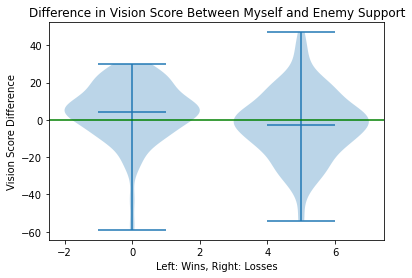

In [39]:
ids = [0, 5] # Arbitrary numbers, the plots need to be properly spaced
mpl.violinplot(total_list,ids,widths=4,showmeans=True)
mpl.axhline(y=0, color='g')
mpl.xlabel("Left: Wins, Right: Losses")
mpl.ylabel("Vision Score Difference")
mpl.title("Difference in Vision Score Between Myself and Enemy Support")
mpl.show()

### Understanding the Model

The left Violin represents the games in which I won, and the right those I lost. You can see here that my average Vision Score was above zero (which is to say, I had more impact on the game's vision overall), and in games I lost, my Vision Score is below zero. They are both quite close to zero, but the winning plot on the left shows that the difference when I win is higher than when I lose, possibly suggesting I win more games if I have a bigger impact on my team's vision. In addition, the spread of the losses is much wider than the wins, meaning that more of my wins are close to or above 0, whereas in the losses they are spread out more normally.

In Conclusion
============================


Thank you for reading this tutorial, and I hope you understand more about both League of Legends, and the Data Science process as well. Thankfully, due to the wealth of statistics at my disposal, I was able to show a variety of different areas to focus on. In working on this project I learned a lot about how I play the game, my strong suits, and more. Hopefully I can take some of this information to mind going forward, and bump those win numbers up. Based purely on my win rate with Tahm Kench, I am already overperforming compared to other players in the same rank, but this project is still helpful going forward. I think this analysis could include more data, like including every game (non-ranked included) or every champion, but I believe my support statistics gave a good enough idea about the Data Science Pipeline. Having more games played would have been helpful as well. My main takeaways are that I generally win games in which I have a better Vision Score than my opponent, I win the majority of my games when alongside characters like Jhin and Ezreal, and that I need to watch out any time I am matched against characters like Brand or Lulu. Lastly, I know that I typically win more games in which I have a high KP, but after a certain point it seems to be less reliable. This is where more data would help confirm or deny that, since I only have my insights and previous experiences to go off of. 

I would like to thank [Riot Games](https://www.riotgames.com/en) for allowing users such as myself to access their data, as well as the staff of CMSC320 for adequately preparing me to undertake such a project. I hope you learned plenty, and take care!